In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 500)

In [3]:
def get_numeric_data(x):
    return [record[:-2] for record in x]

def get_text_data(x):
    return [record[-1] for record in x]

In [4]:
transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

In [5]:
train_df=pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv')
train_df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,"This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read. For instance the intermixing of Chinese revolutionary history - how they kept accusing peo...",Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in December: http://www.audible.com/mt/ellison2?so...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I read it in 2 nights and couldn't put it down. The book is about the quantum theory of many worlds which states that all decisions we make throughout our lives basically create branches, and that each possible path through the decision tree can be thought of as a parallel world. And in this book, someone invents a way to switch between these worlds. This was nicely alluded to/foreshadowed in this quote: \n ""I think about all the choices we've made...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,"Recommended reading to understand what is going on in middle america, and possibly better explain why Trump won. http://www.npr.org/2016/11/09/5013826...",Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot to recommend it. It did drag on a little at the end so I knocked off 1 star - but overall a wow book. \n It's the story of a starship sent to Tau Ceti - the nearest star that has Earth analog planets - to colonize it. The journey there will take generations, and the story is told of the 3rd & 4th (?) generations, which are the ones that reaches Tau Ceti. It is a story of purpose, and how having a purpose affects behavior. A story of politics, an...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


(array([ 30988.,      0.,  28718.,      0.,  72627.,      0., 188972.,
             0., 313688., 265007.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

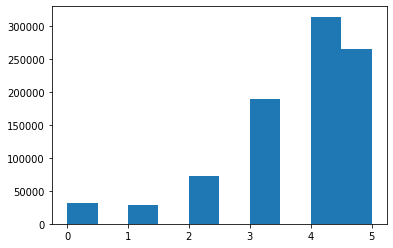

In [6]:
plt.hist(train_df.rating)

In [7]:
nr_users=train_df.groupby('rating').user_id.count().reset_index()
nr_users.columns='rating nr_users'.split()
nr_users

,rating,nr_users
0,0,30988
1,1,28718
2,2,72627
3,3,188972
4,4,313688
5,5,265007


In [8]:
train_df.groupby('rating n_comments n_votes'.split()).user_id.count().reset_index()

,rating,n_comments,n_votes,user_id
0,0,0,-1,1
1,0,0,0,16094
2,0,0,1,3678
3,0,0,2,1490
4,0,0,3,819
...,...,...,...,...
15718,5,443,519,1
15719,5,453,330,1
15720,5,468,472,1
15721,5,537,3167,1


<BarContainer object of 6 artists>

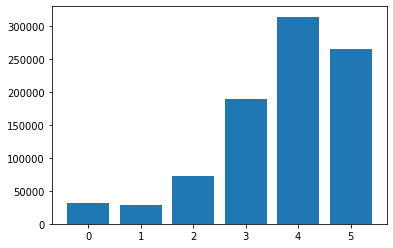

In [9]:
plt.bar(x=nr_users.rating, height=nr_users.nr_users)

In [10]:
def word_count(str) :
    counts=dict()
    words=str.split()
    for word in words :
        if word in counts :
            counts[word]+=1
        else :
            counts[word]=1
    return counts

In [11]:
DATE_FORMAT = '%a %b %d %H:%M:%S %z %Y'

def parse_date(date_str):
    if (date_str != date_str) or (date_str is None):
        return None
    if len(date_str.split()) != 6:
        return None
    else:
        try:
            return datetime.strptime(date_str, DATE_FORMAT)
        except Exception as e:
            print(date_str, e)
        return None

In [12]:
train_df['n_review_words']=train_df.review_text.apply(lambda x: len(x.split()))

In [13]:
from datetime import datetime
train_df['started_at_dt'] = train_df.started_at.apply(lambda x : parse_date(x))
train_df['read_at_dt'] = train_df.read_at.apply(lambda x : parse_date(x))
#train_df['duration_dt'] = (train_df.read_at_dt - train_df.started_at_dt).apply(lambda x: x.dt.days)

In [14]:
train_df.head(10)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,n_review_words,started_at_dt,read_at_dt
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,"This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read. For instance the intermixing of Chinese revolutionary history - how they kept accusing peo...",Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,368,2017-08-15 13:23:18-07:00,2017-08-26 12:05:52-07:00
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in December: http://www.audible.com/mt/ellison2?so...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0,10,None,None
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I read it in 2 nights and couldn't put it down. The book is about the quantum theory of many worlds which states that all decisions we make throughout our lives basically create branches, and that each possible path through the decision tree can be thought of as a parallel world. And in this book, someone invents a way to switch between these worlds. This was nicely alluded to/foreshadowed in this quote: \n ""I think about all the choices we've made...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0,468,2017-03-17 23:45:40-07:00,2017-03-18 23:22:42-07:00
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,"Recommended reading to understand what is going on in middle america, and possibly better explain why Trump won. http://www.npr.org/2016/11/09/5013826...",Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1,19,None,None
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot to recommend it. It did drag on a little at the end so I knocked off 1 star - but overall a wow book. \n It's the story of a starship sent to Tau Ceti - the nearest star that has Earth analog planets - to colonize it. The journey there will take generations, and the story is told of the 3rd & 4th (?) generations, which are the ones that reaches Tau Ceti. It is a story of purpose, and how having a purpose affects behavior. A story of politics, an...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1,736,2016-05-28 00:00:00-07:00,2016-06-26 00:00:00-07:00
5,8842281e1d1347389f2ab93d60773d4d,19398490,ea4a220b10e6b5c796dae0e3b970aff1,4,"A beautiful story. It is rare to encounter a book that does such a good job painting the scenes in your mind - you really felt like you were there and got to know the characters and the people they came across. I generally love WWII books and movies, but wasn't sure if I'd like one featuring a blind girl and a young Nazi radio operator - but he brings a lot of life to them. \n That said, the novel drifts around a lot, and the plotline jumping forward and backward in time drove me nuts. \n I ...",Sun Jan 03 21:20:46 -0800 2016,Tue Sep 20 23:30:15 -0700 2016,Tue Sep 13 11:51:51 -0700 2016,Sat Aug 20 07:03:03 -0700 2016,35,5,258,2016-08-20 07:03:03-07:00,2016-09-13 11:51:51-07:00
6,8842281e1d1347389f2ab93d60773d4d,22318578,5fe9882bfe4b0520a322820c4c55747d,5,5 stars for giving me a better framework for how to organize my stuff and what stuff to keep than I'd ever had before. For instanc

In [15]:
train_df.duration_dt=train_df.duration_dt.astype(str).apply(lambda x: 'nan' if 'nan' in x else(x[:x.find('days')] if 'days' in x else 0)).astype('float64')

AttributeError: 'DataFrame' object has no attribute 'duration_dt'

In [ ]:
train_df.duration_dt.fillna(train_df.duration_dt.mean(), inplace=True)

In [ ]:
train_df[train_df.duration_dt>700000].shape

In [ ]:
train_df.groupby('rating').duration_dt.min()

In [ ]:
plt.hist(train_df.duration_dt.apply(lambda x: -1 if x<0 else(0 if x<10 else(1 if x<25 else(2 if x<50 else 3)))), density=True, stacked=True)

In [ ]:
((train_df.duration_dt>0) & (train_df.duration_dt<5)).sum() 

In [ ]:
train_df.describe()

In [ ]:
features='book_id n_votes n_comments duration_dt review_text'.split()
X_train=train_df[features]
Y_train=train_df.rating

In [ ]:
X_train.head()

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

In [ ]:
param_grid = {'clf__n_estimators': np.linspace(1, 100, 10, dtype=int),
              'clf__min_samples_split': [3, 10],
              'clf__min_samples_leaf': [3],
              'clf__max_features': [7],
              'clf__max_depth': [None],
              'clf__criterion': ['gini'],
              'clf__bootstrap': [False]}

In [ ]:
kfold = StratifiedKFold(n_splits=7)
scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [ ]:
rf_model = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
rf_model.fit(X_train, Y_train)
rf_best = rf_model.best_estimator_

In [ ]:
train_df.groupby('rating').n_review_words.sum()

In [ ]:
test_df=pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv')
test_df.head()

In [ ]:
test_df[test_df.review_text.str.len()<4]